<a href="https://colab.research.google.com/github/Manditar2/NLI-con-red-neuronal-LSTM/blob/main/Proyecto_data_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#@title Cargar datos
df = pd.read_csv('/content/sample_data/snli_1.0_train.csv')
columnas = ['sentence1','sentence2','gold_label']
df = df[columnas]
df.dropna(axis=0, inplace=True) #Se eliminan datos nulos
df.head()

,sentence1,sentence2,gold_label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


In [ ]:
df = df.loc[df['gold_label'] != "-"]   #Se botan las filas que contengan - y neutral
df = df.loc[df['gold_label'] != "neutral"]
df.shape

(3063, 3)

In [ ]:
df = df.sample(frac = 1)
df["gold_label"] = (df["gold_label"] == "contradiction").astype(int)
df.head()

,sentence1,sentence2,gold_label
430,Man wearing black t-shirt sitting at a compute...,the man called off work and was at the zoo all...,1
2369,Young boy jogging through the forest.,A child runs through the woods,0
3914,Three people dressed in red and black stand on...,There are 3 people outside.,0
1442,A pirate is chasing a princess down the sidewalk.,Pirate on the sidewalk,0
4016,A young boy jumps into the water.,The boy is playing in a sandbox.,1


In [ ]:
y = df['gold_label']
len(df)
X = df[['sentence1','sentence2']]

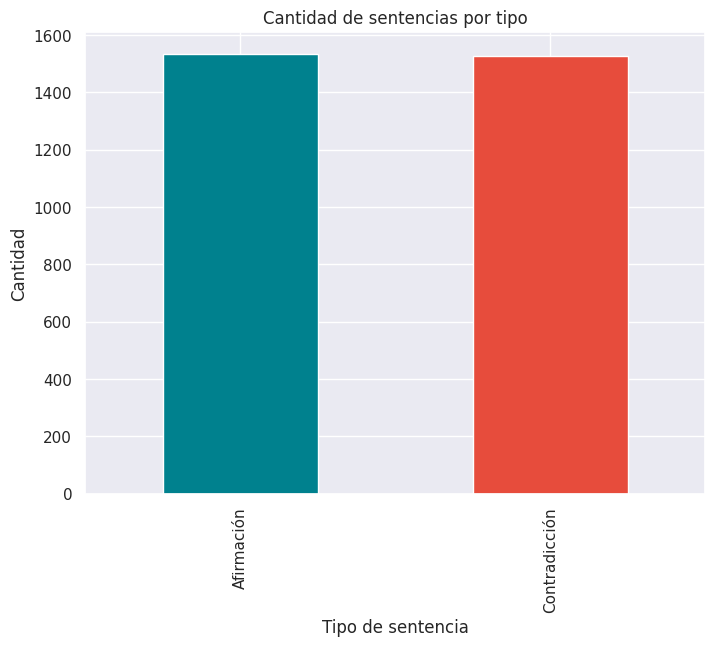

In [ ]:
sns.set(style='darkgrid')
colores = ['#00818E', '#e74c3c']
counts = df['gold_label'].value_counts().rename({0: 'Afirmación', 1: 'Contradicción'})

plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color = colores)
plt.title('Cantidad de sentencias por tipo')
plt.xlabel('Tipo de sentencia')
plt.ylabel('Cantidad')
plt.show()

In [ ]:
#@title Limpieza de datos

def limpiarTexto(texto):
  texto = str(texto).lower()
  texto = re.sub('\[.*?\]', '', texto)
  texto = re.sub('<.*?>+', '', texto)
  texto = re.sub('\n', '', texto)
  texto = re.sub('[%s]' % re.escape(string.punctuation), '', texto)
  texto = re.sub('\w*\d\w*', '', texto)
  return texto

df.head()

,sentence1,sentence2,gold_label
430,Man wearing black t-shirt sitting at a compute...,the man called off work and was at the zoo all...,1
2369,Young boy jogging through the forest.,A child runs through the woods,0
3914,Three people dressed in red and black stand on...,There are 3 people outside.,0
1442,A pirate is chasing a princess down the sidewalk.,Pirate on the sidewalk,0
4016,A young boy jumps into the water.,The boy is playing in a sandbox.,1


In [ ]:
df['sentence1'] = df['sentence1'].apply(limpiarTexto)
df['sentence2'] = df['sentence2'].apply(limpiarTexto)
df.head()

,sentence1,sentence2,gold_label
430,man wearing black tshirt sitting at a computer...,the man called off work and was at the zoo all...,1
2369,young boy jogging through the forest,a child runs through the woods,0
3914,three people dressed in red and black stand on...,there are people outside,0
1442,a pirate is chasing a princess down the sidewalk,pirate on the sidewalk,0
4016,a young boy jumps into the water,the boy is playing in a sandbox,1


In [ ]:
#@title Pre procesamiento
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
  
df['sentence1'] = df['sentence1'].apply(remove_stopwords)
df['sentence2'] = df['sentence2'].apply(remove_stopwords)
df['sentence1'].shape
df['sentence2'].shape


(3063,)

In [ ]:
stemmer = nltk.SnowballStemmer('english')
def stematizar(texto):
  texto = ' '.join(stemmer.stem(word) for word in texto.split(' ')) #Divide el texto, y aplica la función de stematización a cada palabra
  return texto
df['sentence1'] = df['sentence1'].apply(stematizar)
df['sentence2'] = df['sentence2'].apply(stematizar)
df.head()


,sentence1,sentence2,gold_label
430,man wear black tshirt sit comput desk,man call work zoo day,1
2369,young boy jog forest,child run wood,0
3914,three peopl dress red black stand sidewalk fro...,peopl outsid,0
1442,pirat chase princess sidewalk,pirat sidewalk,0
4016,young boy jump water,boy play sandbox,1


In [ ]:
df['sentence1'].shape
df['sentence2'].shape

(3063,)

In [ ]:
#@title Tokenización
sentencias_arreglo = np.asarray([df['sentence1'],df['sentence2']])
print(sentencias_arreglo)
sentencias_arreglo = sentencias_arreglo.reshape(-1,1)

[['man wear black tshirt sit comput desk' 'young boy jog forest'
  'three peopl dress red black stand sidewalk front beig wall adorn graffiti'
  ... 'man perform danger construct work'
  'man khaki pant light shirt hat stand scaffold appli stucco build'
  'woman walk front outdoor mural promin featur portrait bald man']
 ['man call work zoo day' 'child run wood' ' peopl outsid' ...
  'person work' 'man wear hat' 'person walk front outdoor portrait man']]


In [ ]:
sentencias_arreglo.shape

(6126, 1)

In [ ]:
sentencias_arreglo = sentencias_arreglo.reshape(sentencias_arreglo.shape[0])
sentencias_arreglo.shape

(6126,)

In [ ]:
tokenizar = Tokenizer(num_words = 6000)
tokenizar.fit_on_texts(sentencias_arreglo) #Transforma a "número" las palabras dentro del arreglo

In [ ]:
texto_original_seq = tokenizar.texts_to_sequences(df['sentence1']) #Guarda un arreglo que en vez de palabras, posee índices de palabras
texto_original = pad_sequences(texto_original_seq) #Agrega padding para estandarizar el tamaño
hipotesis_seq = tokenizar.texts_to_sequences(df['sentence2'])
hipotesis = pad_sequences(hipotesis_seq)
print(hipotesis)

[[   0    0    0 ...   38 1202  237]
 [   0    0    0 ...   33   36  259]
 [   0    0    0 ...    0    3   21]
 ...
 [   0    0    0 ...    0   27   38]
 [   0    0    0 ...    1    5   41]
 [   0    0    0 ...   60  338    1]]
